In [2]:
!python -V

Python 3.10.0


목표 : LSTM을 이용해 로이터 뉴스 카테고리 분류  

주어진 데이터 : 로이터 뉴스 데이터 파일  
단어 토큰화 후 상위 빈도 1000개 기준으로 저장된 파일

뉴스들을 46개 카테고리로 분류해보자

In [3]:
# GPU 잡히는지 체크
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9392977793458154613
 xla_global_id: -1]

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# 로이터 뉴스 데이터셋 불러오기
from keras.datasets import reuters
from keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
# seed 값 설정
seed = 3
np.random.seed(seed)
tf.random.set_seed(3)

In [6]:
# 로이터 뉴스 데이터 파일 불러오기
import pickle

with open('reuters.p', 'rb') as file:    # james.p 파일을 바이너리 읽기 모드(rb)로 열기
    data_reuters = pickle.load(file)

In [7]:
# 불러온 데이터를 학습셋, 테스트셋으로 나눠서 저장
(X_train, Y_train), (X_test, Y_test) = data_reuters

In [8]:
# 첫번째 뉴스기사
X_train[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 2,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 2,
 2,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 2,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [9]:
print(X_train.shape)   # 뉴스기사
print(Y_train.shape)   # 뉴스 카테고리(정답)
print(X_test.shape)
print(Y_test.shape)

(8982,)
(8982,)
(2246,)
(2246,)


In [10]:
%%time

# 전체 뉴스들의 단어 확인 
news_word_list = []

for i in range(len(X_train)):
    news_word_list = news_word_list + X_train[i]    

CPU times: total: 8 s
Wall time: 17.4 s


In [11]:
# 뉴스 전체의 unique 단어는 1000 개이다.
np.unique(news_word_list)

array([  1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

In [12]:
# 뉴스 카테고리 unique값 갯수 확인 : 46개의 카테고리가 존재한다.
np.unique(Y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [14]:
category = np.max(Y_train) + 1
category

46

In [15]:
# 첫번째 뉴스기사 확인 : 87개의 단어로 이루어진 뉴스이다.
print(len(X_train[0]))
X_train[0]

87


[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 2,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 2,
 2,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 2,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 전처리

# 뉴스: 패딩
X_train_pad = pad_sequences(X_train, maxlen=100)
X_test_pad = pad_sequences(X_test, maxlen=100)

# 카테고리 레이블: 원핫 인코딩
Y_train_onehot = np_utils.to_categorical(Y_train)
Y_test_onehot = np_utils.to_categorical(Y_test)

In [17]:
# 뉴스 기사들이 100개 단어까지 패딩된 것 확인
X_train_pad[:3]  # 첫번째 뉴스 기사 : 100 - 87 = 13개가 패딩

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   2,   2,   8,  43,  10, 447,   5,  25, 207, 270,   5,   2,
        111,  16, 369, 186,  90,  67,   7,  89,   5,  19, 102,   6,  19,
        124,  15,  90,  67,  84,  22, 482,  26,   7,  48,   4,  49,   8,
        864,  39, 209, 154,   6, 151,   6,  83,  11,  15,  22, 155,  11,
         15,   7,  48,   9,   2,   2, 504,   6, 258,   6, 272,  11,  15,
         22, 134,  44,  11,  15,  16,   8, 197,   2,  90,  67,  52,  29,
        209,  30,  32, 132,   6, 109,  15,  17,  12],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   2, 699,   2,   2,  56,   2,   2,
          9,  56,   2,   2,  81,   5,   2,  57, 366, 737, 132,  20,   2,
          7,   2,  49,   2,   2,   2,   2, 699,   2,   8,   7,  10, 24

In [18]:
# 카테고리 레이블은 원핫인코딩된 것 확인
Y_train_onehot[:3]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

# 딥러닝 모델 구성

In [19]:
# 모델의 설정
model = Sequential()
model.add(Embedding(1000, 100))  # 입력 벡터: 전체 단어의 인덱스(1000), 출력 벡터: 100
model.add(LSTM(100, activation='tanh'))     # LSTM(기사 당 단어 수=100, 옵션),  LSTM의 활성화함수 tanh
# model.add(LSTM(100, activation='tanh'))     
model.add(Dense(46, activation='softmax'))

# 모델의 컴파일
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [20]:
# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}_{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

In [22]:
# 모델의 실행
history = model.fit(X_train_pad, Y_train_onehot, batch_size=100, epochs=10, verbose=1, \
                    validation_data=(X_test_pad, Y_test_onehot), callbacks=[early_stopping_callback, checkpointer])

Epoch 1/10
90/90 [==============================] - 1s 14ms/step - loss: 1.6577 - accuracy: 0.5708 - val_loss: 1.7340 - val_accuracy: 0.5419

Epoch 00001: val_loss did not improve from 1.72775
Epoch 2/10
90/90 [==============================] - 1s 11ms/step - loss: 1.5920 - accuracy: 0.5982 - val_loss: 1.6124 - val_accuracy: 0.6015

Epoch 00002: val_loss improved from 1.72775 to 1.61243, saving model to ./model\02_1.6124.hdf5
Epoch 3/10
90/90 [==============================] - 1s 12ms/step - loss: 1.5049 - accuracy: 0.6258 - val_loss: 1.5132 - val_accuracy: 0.6296

Epoch 00003: val_loss improved from 1.61243 to 1.51321, saving model to ./model\03_1.5132.hdf5
Epoch 4/10
90/90 [==============================] - 1s 12ms/step - loss: 1.3723 - accuracy: 0.6548 - val_loss: 1.4348 - val_accuracy: 0.6465

Epoch 00004: val_loss improved from 1.51321 to 1.43479, saving model to ./model\04_1.4348.hdf5
Epoch 5/10
90/90 [==============================] - 1s 11ms/step - loss: 1.3288 - accuracy: 0.66

In [51]:
# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test_pad, Y_test_onehot)[1]))

71/71 [==============================] - 5s 69ms/step - loss: 1.5527 - accuracy: 0.6144

 Test Accuracy: 0.6144


In [52]:
print(type(X_test_pad))
print(X_test_pad.shape)
X_test_pad

<class 'numpy.ndarray'>
(2246, 100)


array([[  5,   2,   7, ..., 510,  17,  12],
       [652, 194,   2, ..., 760,  17,  12],
       [ 13,  10, 139, ...,   8,  17,  12],
       ...,
       [  0,   0,   0, ...,  11,  17,  12],
       [  0,   0,   0, ...,   8,  17,  12],
       [ 47, 758,  15, ...,   2,  17,  12]])

In [56]:
print(type(Y_test_onehot))
print(Y_test_onehot.shape)
Y_test_onehot

<class 'numpy.ndarray'>
(2246, 46)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [53]:
# 검증셋의 오차 변화
y_vloss = history.history['val_loss']

# 학습셋의 오차 변화
y_loss = history.history['loss']

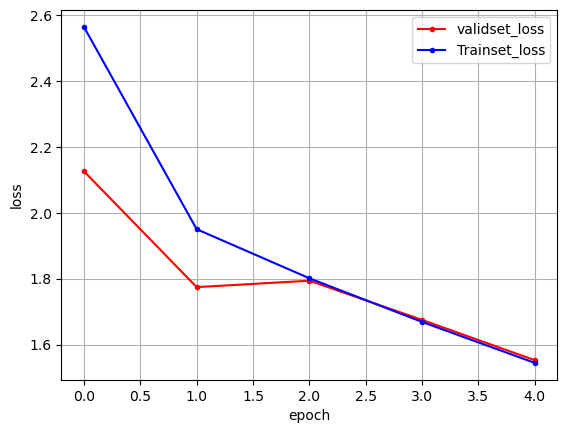

In [54]:
# 그래프로 표현
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='validset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
plt.legend(loc='upper right')

# 그래프에 그리드를 주고 레이블을 표시
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()